In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

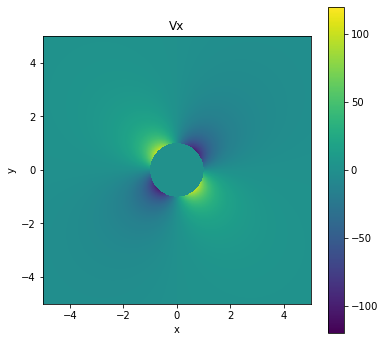

97.9839321942598


In [2]:
RE = 1.5E+6 # unit: m
x = np.linspace(-5*RE, 5*RE, 1000)
y = x
xmesh, ymesh = np.meshgrid(x, y)

alp = 0.01
V0 = 100*1E+3 # unit: m/s
RC = RE

r = np.sqrt(xmesh**2 + ymesh**2) # unit: m
Vx = -2*(1-alp)*V0*((RC/r)**2)*(xmesh*ymesh)/(r**2)
Vx[np.where(r<RE)] = 0

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect(1)
ax.set_title('Vx')
ax.set_xlabel('x')
ax.set_ylabel('y')
pcm = ax.pcolormesh(xmesh/RE, ymesh/RE, Vx/1000, vmin=-120, vmax=120)
fig.colorbar(pcm, ax=ax)
plt.show()
print(np.max(Vx)/1000)


In [5]:
# FAVORITE COLORS (FAVOURITE COLOURS?)
color = ['#6667AB', '#0F4C81', '#5B6770', '#FF6F61', '#645394',
         '#84BD00', '#F6BE00', '#F7CAC9', '#16137E', '#45B8AC']


#
#
# %% TOGGLE
MOON = 'EUROPA'                    # IO, EUROPA, GANYMEDE
FORWARD_BACKWARD = -1          # 1=FORWARD, -1=BACKWARD
GYRO = 1                       # 0=GUIDING CENTER, 1=GYRO MOTION
ION_ELECTRON = 0               # 0=ELECTRON, 1=ION
Z = 2                          # CHARGE (-1 for ELECTRON)
U = 32                         # ATOMIC MASS (32 for SULFUR)
CORES = 79                     # NUMBER OF CPU CORES TO USE (1 - 79)
ALTITUDE = 2                   # ALTITUDE OF STARTING POINTS [m]
ALFVEN_THETA = np.radians(10)  # ANGLE BETWEEN B0 VECTOR AND ALFVEN WING


#
#
# %% SETTINGS FOR THE NEXT EXECUTION
date = '20220420e_EUROPA_test5'
eV_array = np.array([
    2, 4, 6, 8, 10,
    12, 14, 16, 18, 20,
    25, 30, 40, 50, 60, 80, 100,
    200, 300, 400, 500, 600, 800, 1000,
    2500, 5000, 7500,
    10000
])    # [eV]
alp = 0.05
lam = 10.0        # degrees


#
#
# %% CONSTANTS
RJ = 7E+7               # Jupiter半径   単位: m
mJ = 1.90E+27           # Jupiter質量   単位: kg

if MOON == 'IO':
    RE = 1.82E+6        # 衛星半径    単位: m
    mE = 8.94E+22       # 衛星質量    単位: kg
    L94 = 5.9*RJ        # 衛星と木星中心の距離 単位: km
    omgE = 4.1105E-5    # 衛星の公転角速度 単位: rad s^-1
elif MOON == 'EUROPA':
    RE = 1.56E+6        # 衛星半径    単位: m
    mE = 4.8E+22        # 衛星質量    単位: kg
    L94 = 9.4*RJ        # 衛星と木星中心の距離 単位: km
    omgE = 2.0478E-5    # 衛星の公転角速度 単位: rad s^-1

c = float(3E+8)         # 真空中光速    単位: m/s
G = float(6.67E-11)     # 万有引力定数  単位: m^3 kg^-1 s^-2

NA = 6.02E+23           # アボガドロ数
me = float(9.1E-31)     # 電子質量   単位: kg
if ION_ELECTRON == 1:
    me = me*1836*U      # 荷電粒子質量 単位: kg
    print(me)
e = Z*float(1.6E-19)    # 電荷 単位: C

mu = 1.26E-6            # 真空中透磁率  単位: N A^-2 = kg m s^-2 A^-2
Mdip = 1.6E+27          # Jupiterのダイポールモーメント 単位: A m^2
omgJ = 1.75868E-4       # 木星の自転角速度 単位: rad/s
omgR = omgJ-omgE        # 木星の衛星に対する相対的な自転角速度 単位: rad/s
# omgR = omgR*alp         # 減速した共回転の角速度 単位: rad/s
eomg = np.array([-np.sin(np.radians(lam)),
                 0., np.cos(np.radians(lam))])
omgRvec = omgR*eomg


#
#
# %% 途中計算でよく出てくる定数の比
A1 = e/me                        # 運動方程式内の定数
A2 = (mu*Mdip)/(4*np.pi)         # ダイポール磁場表式内の定数
# A1 = float(-1.7582E+11)        # 運動方程式内の定数
# A2 = 1.60432E+20               # ダイポール磁場表式内の定数
A3 = 4*3.141592*me/(mu*Mdip*e)   # ドリフト速度の係数


# 木星とtrace座標系原点の距離(x軸の定義)
R0 = L94*(np.cos(np.radians(lam)))**(-2)
R0x = R0
R0y = 0
R0z = 0
R0vec = np.array([R0x, R0y, R0z])

# Europaのtrace座標系における位置
eurx = L94*math.cos(math.radians(lam)) - R0x
eury = 0 - R0y
eurz = L94*math.sin(math.radians(lam)) - R0z

# 遠方しきい値(z方向) 磁気緯度で設定
z_p_rad = math.radians(15.0)      # 北側
z_m_rad = -math.radians(2.0)       # 南側

In [24]:
lam = 10 # degrees

def OMEGA(Rvec, Hlam):
    """
    `Rvec` ... <ndarray> ダイポール原点の位置ベクトル
    """
    # Hlam = np.radians(5)  # スケールハイト的な

    r = np.sqrt(Rvec[0]**2+Rvec[1]**2+Rvec[2]**2)
    maglat = np.arccos(Rvec[2]/r)   # unit: radian
    # print('MAGLAT: ', math.degrees(maglat))

    lamr = np.radians(90-lam)  # 余緯度に変換
    dist = 1-(1-alp)*np.exp(-((maglat-lamr)/Hlam)**2)

    omg = omgR*dist

    # print('LOCAL ALPHA: ', dist, math.degrees(maglat))

    return omg

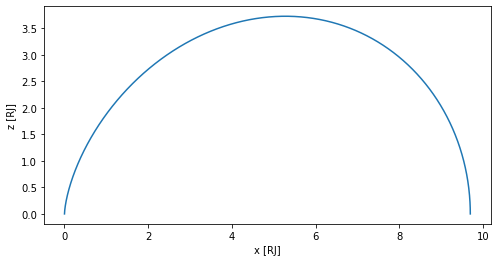

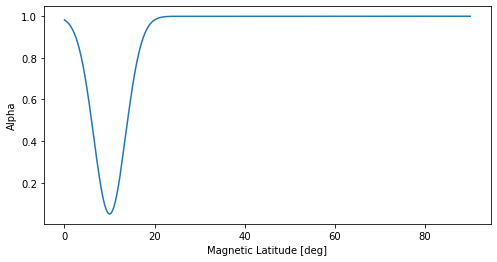

In [77]:
x = np.linspace(0.001, R0-0.1, 5000)
z = np.sqrt((R0*(x**2))**(2/3) - x**2)
r = np.sqrt(x**2 + z**2)
maglat = np.arcsin(z/r)
Rvec = np.array([x,np.zeros(x.shape), z])
omg = OMEGA(Rvec, np.radians(5))

fig, ax = plt.subplots(figsize=(8,4))
ax.set_xlabel('x [RJ]')
ax.set_ylabel('z [RJ]')
ax.plot(x/RJ, z/RJ)
plt.show()

fig, ax = plt.subplots(figsize=(8,4))
ax.set_xlabel('Magnetic Latitude [deg]')
ax.set_ylabel('Alpha')
ax.plot(np.degrees(maglat), omg/omgR)
plt.show()

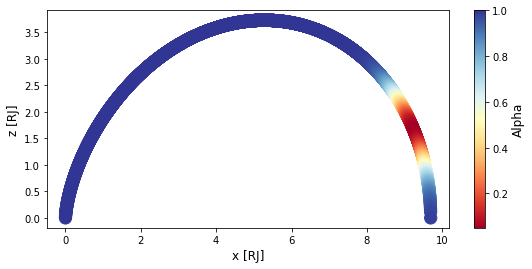

In [85]:
# カラーマップ
cm = plt.cm.get_cmap('RdYlBu')
 
# axをfigureに設定する
fig, ax = plt.subplots(figsize=(9,4))
ax.set_xlabel('x [RJ]', fontsize=12)
ax.set_ylabel('z [RJ]', fontsize=12)

# axに散布図を描画、戻り値にPathCollectionを得る
mappable = ax.scatter(x/RJ, z/RJ, s=150, c=omg/omgR, cmap=cm)
 
# カラーバーを付加
pp = fig.colorbar(mappable, ax=ax)
pp.set_label('Alpha', fontsize=12)
 
# 表示
plt.show()